In [25]:
# 运行库导入
import numpy as np
from sklearn.linear_model import RidgeCV
import pandas as pd
from joblib import Parallel, delayed
import time
import matplotlib.pyplot as plt
from scipy import stats
import os

In [2]:
# 数据导入与预处理
train_data = pd.read_csv("D:/documents_for_university/大三下/计算与优化/小组作业/数据/数据与代码/train.csv")
test_data = pd.read_csv("D:/documents_for_university/大三下/计算与优化/小组作业/数据/数据与代码/test.csv")

X_train = train_data.iloc[:, :-1].to_numpy()  # 转换为 NumPy 数组
Y_train = train_data.iloc[:, [-1]].to_numpy()
Y_train_scaled = (Y_train - np.mean(Y_train)) / np.std(Y_train)
X_test = test_data.iloc[:, :-1].to_numpy()    # 转换为 NumPy 数组
Y_test = test_data.iloc[:, [-1]].to_numpy()
Y_test_scaled = (Y_test - np.mean(Y_test)) / np.std(Y_test)

In [3]:
# 梯度下降求解方法
class Gradient_Method:
    def __init__(self,X,y,lambda_list):
        self.X = X
        self.y = y
        # 读取数据维度
        self.n = X.shape[0]
        self.p = X.shape[1]
        # self.init_sigma
        self.init_beta = np.zeros(self.p).reshape(-1,1)
        self.lambda_list = lambda_list
        self.lambda_solution_dict = {}
        self.loss_dict = {}
        print("Initialization Done.")

    # 初始sigma_0的确定(岭回归解的无穷范数的三倍)
    def find_init_sigma(self,curr_lambda):
        # 使用交叉验证岭回归来选择最佳正则化强度
        ridge_lambda_grid = [0.00001,0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        ridge_cv = RidgeCV(alphas=ridge_lambda_grid, fit_intercept=False, cv=5)
        ridge_cv.fit(self.X, self.y)
        ridge_lambda = ridge_cv.alpha_
        ridge_solution = ridge_cv.coef_[0,:].reshape(-1,1)
        self.init_beta = ridge_solution # 用岭回归结果作为beta初始值
        L_infinity_nor_of_ridge_solution = max(ridge_solution).item()
        ridge_main_loss = self.Loss(ridge_solution.reshape(-1,1))
        print(f"lambda: {ridge_lambda},ridge_main_loss: {ridge_main_loss}")
        # 定义sigma的初值
        return 3 * L_infinity_nor_of_ridge_solution

    # 定义核函数近似的L0正则项
    def kernel_func_reg(self,curr_beta,curr_sigma,curr_lambda):
        return curr_lambda * (self.p - np.sum(np.exp(-(curr_beta**2)/(2*curr_sigma**2))))

    # 定义损失函数
    def Loss(self,curr_beta):
        return ((1/self.n)*sum(((self.X @ curr_beta - self.y) ** 2))).item()

    # 定义总损失
    def total_Loss(self,curr_beta,curr_sigma,curr_lambda):
        return (self.Loss(curr_beta) + self.kernel_func_reg(curr_beta,curr_sigma,curr_lambda))

    # 定义损失部分的梯度
    def Loss_grad(self,curr_beta):
        return ((2/self.n)*((self.X).T) @ (self.X @ curr_beta - self.y))

    # 定义正则项部分的梯度
    def kernel_func_reg_grad(self,curr_beta,curr_sigma,curr_lambda):
        return curr_lambda * (np.exp(-(curr_beta**2)/(2*curr_sigma**2)) * (curr_beta/(curr_sigma**2)))

    # 定义总梯度
    def Loss_total_grad(self,curr_beta,curr_sigma,curr_lambda):
        return (self.Loss_grad(curr_beta) + self.kernel_func_reg_grad(curr_beta,curr_sigma,curr_lambda))

    # 定义迭代步长的回溯直线搜索(用于给定lambda和sigma后的梯度下降过程)
    def backtracking_line_search(self,curr_beta,curr_sigma,curr_lambda,grad, eta_init=1.0, c=0.2, rho=0.4):
        eta = eta_init
        current_loss = self.total_Loss(curr_beta,curr_sigma,curr_lambda)
        grad_norm = np.sum(grad ** 2)  # 梯度的平方范数
        # 验证条件
        while self.total_Loss(curr_beta - eta * grad, curr_sigma, curr_lambda).item() > (current_loss - c * eta * grad_norm).item():
            descent_loss = self.total_Loss(curr_beta - eta * grad, curr_sigma, curr_lambda).item()
            condition_loss = (current_loss - c * eta * grad_norm).item()
            eta *= rho
            if eta < 1e-7:  # 防止步长过小
                break
        return eta

    # 定义给定正则化强度和sigma后的梯度下降过程
    def gradient_descent_procedure_given_sigma(self,curr_beta,curr_lambda,curr_sigma,max_iter = 1000,tol=1e-6):
        for i in range(max_iter):
            grad = self.Loss_total_grad(curr_beta,curr_sigma,curr_lambda)
            eta = self.backtracking_line_search(curr_beta,curr_sigma,curr_lambda,grad)
            beta_new = curr_beta - eta * grad
            if np.linalg.norm(beta_new - curr_beta) < tol:
                print(f"Converged at iteration {i}")
                break
            curr_beta = beta_new
            if i % 100 == 0:
                curr_total_loss = self.total_Loss(curr_beta,curr_sigma,curr_lambda)
                self.loss_dict[curr_lambda].append(curr_total_loss)
                print(f"Iteration {i}, Loss: {curr_total_loss}, Step size: {eta}")
        return curr_beta

    # 定义给定正则化强度lambda后的梯度下降求解过程
    def gradient_descent_procedure(self, curr_lambda,threshold = 1e-6):
        # 首先确定初始sigma
        curr_sigma = self.find_init_sigma(curr_lambda)
        curr_beta = self.init_beta
        updated_beta = self.gradient_descent_procedure_given_sigma(curr_beta,curr_lambda,curr_sigma,max_iter = 100)

        sigma_rescale_cnt = 0
        while (np.sum((updated_beta - curr_beta)**2) > threshold) & (sigma_rescale_cnt <= 10):
            # 以0.5为因子缩小sigma
            curr_sigma = 0.5 * curr_sigma
            sigma_rescale_cnt += 1
            print("sigma_rescaling!")
            curr_beta = updated_beta
            curr_max_iter = 500 if sigma_rescale_cnt <= 10 else 5000
            updated_beta = self.gradient_descent_procedure_given_sigma(curr_beta,curr_lambda,curr_sigma,max_iter = curr_max_iter)
        # 返回最后求解出的beta和对应的sigma
        return updated_beta,curr_sigma

    # 根据lambda_list开始搜索
    def solve(self):
        # 存储对应的lambda和优化结果
        lambda_solution_dict = {}
        for i in range(0,len(self.lambda_list)):
            curr_lambda = self.lambda_list[i]
            self.loss_dict[curr_lambda] = []
            print(f"Curr Lambda:{curr_lambda}")
            # 给定lambda,开始梯度下降进行求解
            curr_solution,curr_sigma_end = self.gradient_descent_procedure(curr_lambda)
            curr_loss = self.total_Loss(curr_solution,curr_sigma_end,curr_lambda) # 计算总梯度 
            curr_MSE = self.Loss(curr_solution) # 计算MSE
            curr_reg_loss = self.kernel_func_reg(curr_solution,curr_sigma_end,curr_lambda) # 计算正则项损失
            lambda_solution_dict[curr_lambda] = (curr_solution,curr_loss,curr_sigma_end,curr_MSE) 
            print(f"Lambda {curr_lambda}, Total_Loss: {curr_loss}, reg_loss: {curr_reg_loss},main loss: {curr_loss - curr_reg_loss} , final_sigma: {curr_sigma_end}")
            print()
        self.lambda_solution_dict = lambda_solution_dict
        return lambda_solution_dict

    # 并行化求解
    def solve_parallel(self):
        def run_lambda(lam):
            self.loss_dict[lam] = []
            print(f"Curr Lambda: {lam}")
            curr_solution, curr_sigma_end = self.gradient_descent_procedure(lam)
            curr_loss = self.total_Loss(curr_solution, curr_sigma_end, lam)
            curr_MSE = self.Loss(curr_solution)
            curr_reg_loss = self.kernel_func_reg(curr_solution, curr_sigma_end, lam)
            return lam, (curr_solution, curr_loss, curr_sigma_end, curr_MSE)

        # 记录开始时间
        start_time = time.time()
        # 并行执行
        results = Parallel(n_jobs=-1, verbose=10)(delayed(run_lambda)(lam) for lam in self.lambda_list)
        # 收集结果
        lambda_solution_dict = {}
        for lam, result in results:
            curr_solution, curr_loss, curr_sigma_end, curr_MSE = result
            lambda_solution_dict[lam] = (curr_solution, curr_loss, curr_sigma_end, curr_MSE)
            print(
                f"Lambda {lam}, Total_Loss: {curr_loss}, reg_loss: {curr_loss - curr_MSE}, main loss: {curr_MSE}, final_sigma: {curr_sigma_end}")
            print()

        # 记录结束时间
        end_time = time.time()
        print(f"Total time: {end_time - start_time:.2f} seconds")

        self.lambda_solution_dict = lambda_solution_dict
        return lambda_solution_dict
    
    def predict(self,X_test,y_test):
        n = X_test.shape[0]
        test_data_dict = {}
        for lamb in self.lambda_list:
            curr_beta = self.lambda_solution_dict[lamb][0]
            curr_MSE = ((1/n)*sum(((X_test @ curr_beta - y_test) ** 2))).item()
            test_data_dict[lamb] = curr_MSE
        return test_data_dict

In [4]:
# 启动
# 设定一个lambda网格
lambda_list = [1e-07,2e-07,4e-07,8e-07,
               1e-06,2e-06,4e-06,8e-06,
               1e-05,2e-05,4e-05,8e-05,
               1e-04,2e-04,4e-04,8e-04,
               1e-03,2e-03,4e-03,8e-03]
# 定义梯度下降类
Gradient_Method_obj = Gradient_Method(X_train,Y_train_scaled,lambda_list)
# 非并行版本
#solution_dict = Gradient_Method_obj.solve()
# 执行lambda参数的并行搜索
solution_dict = Gradient_Method_obj.solve_parallel() 
test_MSE_dict = Gradient_Method_obj.predict(X_test,Y_test_scaled)

Initialization Done.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:  1.0min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:  1.4min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  2.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  2.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.7min remaining:   28.2s


Lambda 1e-07, Total_Loss: 0.07203403255014834, reg_loss: 2.409470783819312e-05, main loss: 0.07200993784231015, final_sigma: 0.00023398699791149654

Lambda 2e-07, Total_Loss: 0.07240462404425285, reg_loss: 4.721469587248839e-05, main loss: 0.07235740934838036, final_sigma: 0.00023398699791149654

Lambda 4e-07, Total_Loss: 0.07289675920297903, reg_loss: 9.2457421401404e-05, main loss: 0.07280430178157762, final_sigma: 0.00023398699791149654

Lambda 8e-07, Total_Loss: 0.07300471775662071, reg_loss: 0.00018243616677773855, main loss: 0.07282228158984297, final_sigma: 0.00023398699791149654

Lambda 1e-06, Total_Loss: 0.07323791076547416, reg_loss: 0.00022802346096882642, main loss: 0.07300988730450533, final_sigma: 0.00023398699791149654

Lambda 2e-06, Total_Loss: 0.074073739726183, reg_loss: 0.0004181376673836473, main loss: 0.07365560205879935, final_sigma: 0.00023398699791149654

Lambda 4e-06, Total_Loss: 0.07493578636562956, reg_loss: 0.0007963623441036988, main loss: 0.074139424021525

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min finished


In [5]:
# 打印lambda:Test_MSE键值对
print(f"Test MSE:{test_MSE_dict}")
# print(solution_dict[lambda_list[0]][0])

Test MSE:{1e-07: 0.12140106917636288, 2e-07: 0.12150375162790165, 4e-07: 0.12170247477500956, 8e-07: 0.12164389493146234, 1e-06: 0.12180896551599286, 2e-06: 0.12148588534914717, 4e-06: 0.12159234138241273, 8e-06: 0.12184360049376423, 1e-05: 0.12158535488556228, 2e-05: 0.1205735115091703, 4e-05: 0.12036480402262884, 8e-05: 0.12038313800841596, 0.0001: 0.12236285286392518, 0.0002: 0.12046058079303479, 0.0004: 0.12665630115568463, 0.0008: 0.13538941798738482, 0.001: 0.1542818283929757, 0.002: 0.1625473029107111, 0.004: 0.1485334576454803, 0.008: 0.20239727909780522}


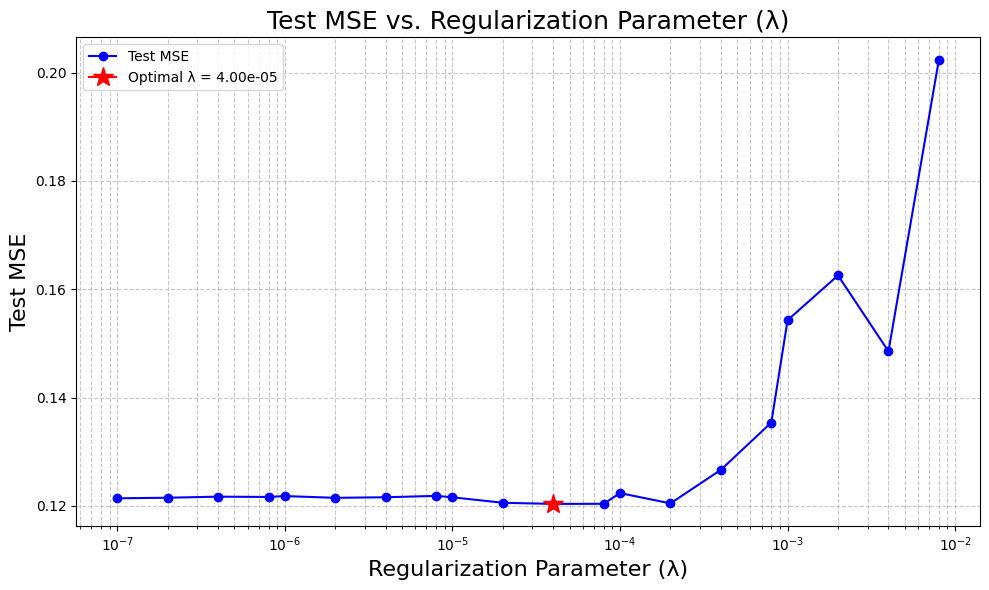

In [22]:
# 绘制标注最优值点的test_MSE-lambda折线图
lambda_values = list(test_MSE_dict.keys())
mse_values = list(test_MSE_dict.values())

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, mse_values, marker='o', linestyle='-', color='b', label='Test MSE')

# 标记最优 lambda
optimal_lambda = lambda_values[np.argmin(mse_values)]
optimal_mse = min(mse_values)
plt.plot(optimal_lambda, optimal_mse, marker='*', markersize=15, color='r', label=f'Optimal λ = {optimal_lambda:.2e}')

# 设置对数刻度
plt.xscale('log')
plt.xlabel('Regularization Parameter (λ)',fontsize = 16)
plt.ylabel('Test MSE',fontsize = 16)
plt.title('Test MSE vs. Regularization Parameter (λ)',fontsize = 18)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()

# 图片保存
plt.savefig('D:/documents_for_university/大三下/计算与优化/小组作业/数据/图片/lambda_mse_plot.png', dpi=500, bbox_inches='tight')  
# 显示图表
plt.show()

In [8]:
#需要自己指定一个lambda参数使用.solve()方法重新执行一下
specific_lambda_list = [4e-05]
# 定义梯度下降类
specific_Gradient_Method_obj = Gradient_Method(X_train,Y_train_scaled,specific_lambda_list)
# 非并行版本
specific_solution_dict = specific_Gradient_Method_obj.solve()

Initialization Done.
Curr Lambda:4e-05
lambda: 100.0,ridge_main_loss: 0.09547626903117043
Iteration 0, Loss: 0.09535315816578328, Step size: 0.16000000000000003
sigma_rescaling!
Iteration 0, Loss: 0.0897427075431655, Step size: 0.010240000000000004
Iteration 100, Loss: 0.08735958212466802, Step size: 0.4
Iteration 200, Loss: 0.08577660435706966, Step size: 0.025600000000000008
Iteration 300, Loss: 0.08475889907967928, Step size: 0.010240000000000004
Iteration 400, Loss: 0.0838045286315082, Step size: 0.010240000000000004
sigma_rescaling!
Iteration 0, Loss: 0.08381645441490498, Step size: 0.025600000000000008
Iteration 100, Loss: 0.0832931995908204, Step size: 0.010240000000000004
Iteration 200, Loss: 0.08281844473108131, Step size: 0.4
Iteration 300, Loss: 0.08234396951501799, Step size: 0.010240000000000004
Iteration 400, Loss: 0.08194844435019981, Step size: 0.010240000000000004
sigma_rescaling!
Iteration 0, Loss: 0.08309190975152018, Step size: 0.010240000000000004
Iteration 100, Lo

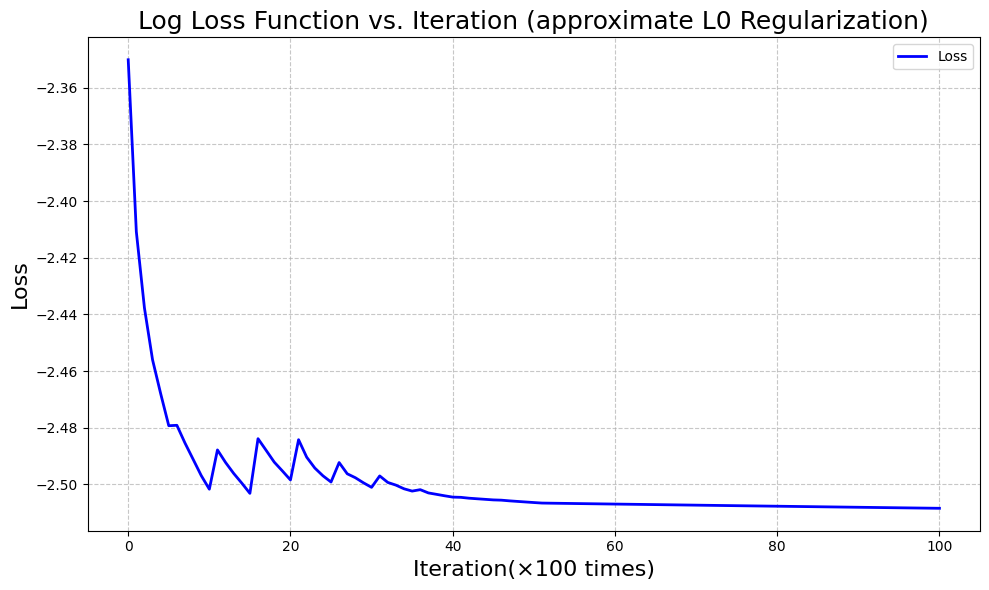

In [21]:
# 梯度下降过程的损失可视化
losses = np.log(specific_Gradient_Method_obj.loss_dict[specific_lambda_list[0]])
# 可视化损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, label='Loss', color='blue', linewidth=2)
plt.title('Log Loss Function vs. Iteration (approximate L0 Regularization)', fontsize=18)
plt.xlabel('Iteration(×100 times)', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
# 图片保存
plt.savefig('D:/documents_for_university/大三下/计算与优化/小组作业/数据/图片/loss_descent_curve.png', dpi=500, bbox_inches='tight') 

plt.show()

261


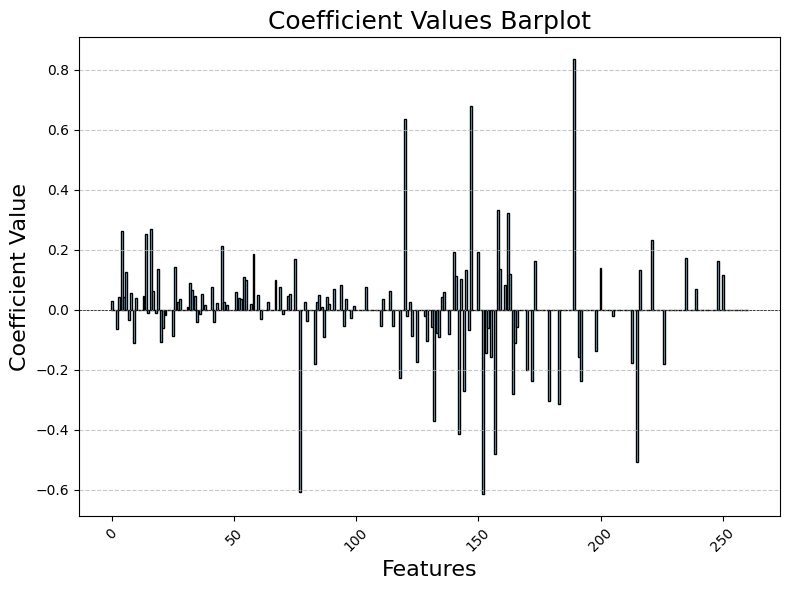

In [23]:
# 系数向量可视化
beta = solution_dict[specific_lambda_list[0]][0].flatten()
feature_names = [i for i in range(0,len(beta))]
print(len(beta))
# 条形图
plt.figure(figsize=(8, 6))
plt.bar(feature_names, beta.flatten(), color='skyblue', edgecolor='black')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # 添加 y=0 线
plt.title('Coefficient Values Barplot', fontsize=18)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Coefficient Value', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# 图片保存
plt.savefig('D:/documents_for_university/大三下/计算与优化/小组作业/数据/图片/beta_vector_barplot.png', dpi=500, bbox_inches='tight') 
plt.show()

In [14]:
# 根据系数的绝对值大小选出最应该被保留的和最应该被舍弃的变量前top_n名
#feature_names = X_train.columns.tolist()
#top_n = 15
#bottom_n = 15

#abs_beta = np.abs(beta)
# top_n 排序
#sorted_indices = np.argsort(abs_beta)[::-1]  # 按绝对值降序排序
#top_n_indices = sorted_indices[:top_n]  # 前 top_n 大
#bottom_n_indices = sorted_indices[-bottom_n:] # 后 bottom_n 小

# 映射到特征名称
# most_useful_features = [feature_names[i] for i in top_n_indices]
# most_useless_features = [feature_names[i] for i in bottom_n_indices]
# print(most_useful_features)
# print()
# print(most_useless_features)

In [5]:
# 基于bootstrap对参数进行检验以确定变量选择
# Bootstrap 和并行求解部分
def bootstrap_sample(X, y, n_samples):
    """有放回重抽样，生成 Bootstrap 样本"""
    indices = np.random.randint(0, n_samples, size=n_samples)
    X_boot = X[indices]
    y_boot = y[indices]
    return X_boot, y_boot

def run_bootstrap_iteration(i, X_train, Y_train_scaled, lambda_list, n_samples):
    """单次 Bootstrap 迭代，求解参数向量"""
    # 生成 Bootstrap 样本
    np.random.seed(i) # 使用bootstrap序号作为随机数种子，确保结果可复现
    X_boot, y_boot = bootstrap_sample(X_train, Y_train_scaled, n_samples)
    #print(f"完成了第{i}次重抽样,将开始求解.")
    
    # 初始化 Gradient_Method 对象
    gm = Gradient_Method(X_boot, y_boot, lambda_list)
    
    # 求解
    solution_dict = gm.solve()
    beta_boot = solution_dict[lambda_list[0]][0]  # 假设单 lambda
    
    return i, beta_boot

# 主程序
n_features = X_train.shape[1]
np.random.seed(2022111969)
lambda_list = [4e-05]  # 单 lambda 示例
n_bootstraps = 500  # Bootstrap 次数，可根据需要调整
n_samples = X_train.shape[0]  # 保持样本量不变

# 记录开始时间
start_time = time.time()

# 并行运行 Bootstrap
results = Parallel(n_jobs=-1)(delayed(run_bootstrap_iteration)(i, X_train, Y_train_scaled, lambda_list, n_samples) for i in range(n_bootstraps))

# 创建 DataFrame 存储所有 beta_boot
beta_boot_df = pd.DataFrame(index=range(n_bootstraps), columns=[f"beta_{j}" for j in range(n_features)])
for i, beta_boot in results:
    beta_boot_df.iloc[i] = beta_boot.flatten()

# 记录结束时间
end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")

# 保存到外部文件
beta_boot_df.to_csv("D:/documents_for_university/大三下/计算与优化/小组作业/数据/bootstrap结果/bootstrap_beta_results.csv", index=False)
print("Bootstrap results saved to 'bootstrap_beta_results.csv'")


Total time: 5923.45 seconds
Bootstrap results saved to 'bootstrap_beta_results.csv'


In [6]:
print(beta_boot_df)

       beta_0    beta_1    beta_2    beta_3    beta_4    beta_5    beta_6  \
0    0.030345 -0.000003 -0.000002  0.013242  0.311503      -0.0  0.062631   
1    0.038971 -0.036803 -0.003645    0.0859  0.416898 -0.011347  0.212735   
2    0.039396 -0.147136  0.024891  0.081652  0.398878  0.027363  0.130812   
3    0.020946 -0.000001 -0.065067  0.046047  0.272111  0.043602  0.163635   
4     0.07015 -0.000001  0.000005  0.022446  0.251249  0.037159  0.177308   
..        ...       ...       ...       ...       ...       ...       ...   
495   0.06311 -0.058519  0.050426  0.055019  0.324265  0.075492  0.212077   
496  0.000011 -0.000001 -0.075825  0.019438  0.238476  0.064569  0.166055   
497  0.069869 -0.051327  0.040275  0.020022  0.263942  0.060564  0.154548   
498   0.06321  0.000004 -0.110446   0.03587  0.237329 -0.000005  0.128682   
499  0.031465  -0.00001  0.014082  0.085281  0.317809  0.037407  0.149107   

       beta_7    beta_8    beta_9  ...  beta_251  beta_252  beta_253  \
0  

In [17]:
# 对bootstrap得到的参数向量进行统计推断
# 直接读取上一个单元块的执行结果
beta_boot_df = pd.read_csv("D:/documents_for_university/大三下/计算与优化/小组作业/数据/bootstrap结果/bootstrap_beta_results_500.csv")
# 示例：计算置信区间和假设检验（基础实现）
confidence_level = 0.90
lower_percentile = (1 - confidence_level) / 2
upper_percentile = 1 - lower_percentile
confidence_intervals = pd.DataFrame({
    'lower': beta_boot_df.quantile(lower_percentile),
    'upper': beta_boot_df.quantile(upper_percentile)
})
print(f"\n{confidence_level*100}% Confidence Intervals for each beta:")
print(confidence_intervals)



# 假设检验：检查置信区间是否包含 0
feature_names = train_data.iloc[:, :-1].columns.to_list()
significant_vars = (confidence_intervals['lower'] > 0) | (confidence_intervals['upper'] < 0)

print(significant_vars)
print(sum(significant_vars))  # 统计 True 的数量

print("\nSignificant variables (where 0 is not in CI):")
significant_indices = np.where(significant_vars)[0]  # 转换为整数索引
print([feature_names[i] for i in significant_indices])  # 使用列表推导式提取特征名


90.0% Confidence Intervals for each beta:
             lower     upper
beta_0    0.000003  0.067797
beta_1   -0.106693  0.003731
beta_2   -0.100931  0.026998
beta_3    0.000004  0.083788
beta_4    0.187414  0.371290
...            ...       ...
beta_256 -0.000131  0.336441
beta_257 -0.214906  0.202668
beta_258 -0.158866  0.332750
beta_259 -1.096809  0.559358
beta_260 -4.195501  0.000005

[261 rows x 2 columns]
beta_0       True
beta_1      False
beta_2      False
beta_3       True
beta_4       True
            ...  
beta_256    False
beta_257    False
beta_258    False
beta_259    False
beta_260    False
Length: 261, dtype: bool
33

Significant variables (where 0 is not in CI):
['PID', 'Lot Area', 'Overall Qual', 'Year Built', 'BsmtFin SF 2', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Bedroom AbvGr', 'Garage Cars', 'Screen Porch', 'Land Contour_mean', 'Neighborhood_mean', 'Roof Matl_mean', 'Mas Vnr Type_mean', 'Kitchen Qual_mean', 'Neighborhood_freq', 'Bldg Type_freq', 'Kitchen Qual_f


Shapiro-Wilk Test for beta_0:
Statistic = 0.9580, p-value = 0.0000
beta_0 fails normality test at 90.0% confidence level

Shapiro-Wilk Test for beta_3:
Statistic = 0.9431, p-value = 0.0000
beta_3 fails normality test at 90.0% confidence level

Shapiro-Wilk Test for beta_4:
Statistic = 0.9939, p-value = 0.0411
beta_4 fails normality test at 90.0% confidence level

Shapiro-Wilk Test for beta_6:
Statistic = 0.9882, p-value = 0.0005
beta_6 fails normality test at 90.0% confidence level

Shapiro-Wilk Test for beta_10:
Statistic = 0.5543, p-value = 0.0000
beta_10 fails normality test at 90.0% confidence level

Shapiro-Wilk Test for beta_14:
Statistic = 0.9961, p-value = 0.2620
beta_14 passes normality test at 90.0% confidence level

Shapiro-Wilk Test for beta_16:
Statistic = 0.9968, p-value = 0.4224
beta_16 passes normality test at 90.0% confidence level

Shapiro-Wilk Test for beta_19:
Statistic = 0.9836, p-value = 0.0000
beta_19 fails normality test at 90.0% confidence level

Shapiro-Wilk 

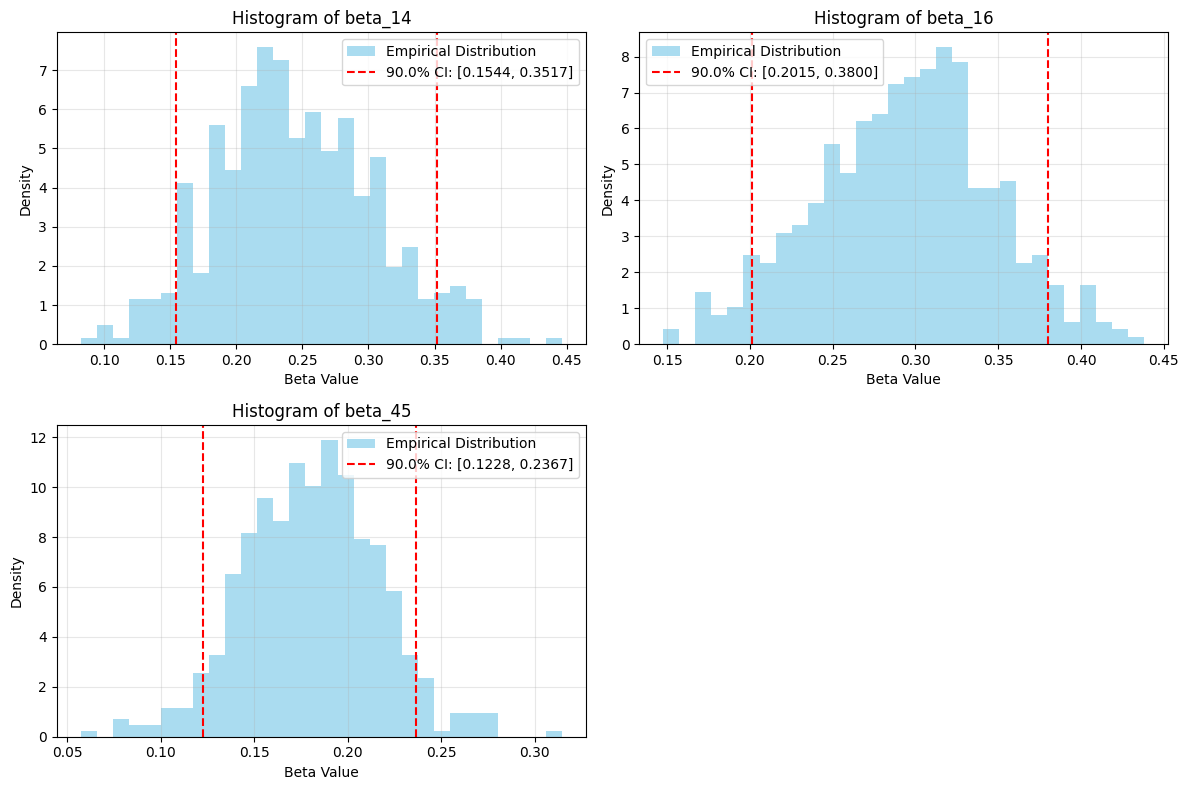

In [31]:
# 正态性检验和直方图绘制
confidence_level_for_normal_test = 0.9
alpha = 1 - confidence_level_for_normal_test  # 显著性水平，例如 0.10
normal_features = []

for idx, feature in enumerate(beta_boot_df.columns):
    if significant_vars[idx]:  # 只对显著特征进行检验
        data = beta_boot_df[feature].dropna()  # 去除 NaN 值
        stat, p_value = stats.shapiro(data)
        print(f"\nShapiro-Wilk Test for {feature}:")
        print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")
        if p_value > alpha:  # 接受正态性假设
            print(f"{feature} passes normality test at {confidence_level_for_normal_test*100}% confidence level")
            normal_features.append(feature)
        else:
            print(f"{feature} fails normality test at {confidence_level_for_normal_test*100}% confidence level")

# 绘制通过正态性检验的变量的直方图
if normal_features:
    n_rows = (len(normal_features) + 1) // 2  # 每行最多 2 个子图
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows), squeeze=False)
    axes = axes.flatten()  # 展平二维数组，便于索引

    for idx, feature in enumerate(normal_features):
        ax = axes[idx]
        data = beta_boot_df[feature].dropna()
        ax.hist(data, bins=30, density=True, alpha=0.7, color='skyblue', label='Empirical Distribution')
        
        # 标注置信区间
        lower = confidence_intervals['lower'][feature]
        upper = confidence_intervals['upper'][feature]
        ax.axvline(lower, color='r', linestyle='--', label=f'{confidence_level*100}% CI: [{lower:.4f}, {upper:.4f}]')
        ax.axvline(upper, color='r', linestyle='--')
        
        ax.set_title(f'Histogram of {feature}')
        ax.set_xlabel('Beta Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 隐藏多余的子图
    for idx in range(len(normal_features), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(f'D:/documents_for_university/大三下/计算与优化/小组作业/数据/bootstrap结果/normal_distribution_histograms_{confidence_level*100}.png', dpi=500, bbox_inches='tight')
    print(f"Histograms saved as 'normal_distribution_histograms_{confidence_level*100}.png'")
    plt.show()
else:
    print("No features passed the normality test.")